In [3]:
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [39]:
def loading_data(datanumber):
    df = pd.read_csv('dataset/dataset_' + str(datanumber) +'.txt', sep=',', header=None)

In [72]:
def data_visulization():
    # read dataset file
    loading_data(1)
    df_sitting = df[df[24] == 1].values
    plt.plot(df_sitting[15000:20000, 18:21])
    plt.plot(df_sitting[15000:20000,22:24])
    df_lying = df[df[24] == 2].values
    plt.plot(df_lying[15000:20000,18:21])
    plt.plot(df_lying[15000:20000,22:24])
    df_standing = df[df[24] == 3].values
    plt.plot(df_standing[15000:20000, 18:21])
    plt.plot(df_standing[15000:20000, 22:24])
    df_washingdish = df[df[24] == 4].values
    plt.plot(df_washingdish[15000:20000, 18:21])
    plt.plot(df_washingdish[15000:20000, 22:24])
    df_vacuum = df[df[24] == 5].values
    plt.plot(df_vacuum[15000:20000, 18:21])
    plt.plot(df_vacuum[15000:20000, 22:24])
    df_sweep = df[df[24] == 6].values
    plt.plot(df_sweep[15000:20000, 18:21])
    plt.plot(df_sweep[15000:20000, 22:24])
    df_walking = df[df[24] == 7].values
    plt.plot(df_walking[15000:20000, 18:21])
    plt.plot(df_walking[15000:20000, 22:24])
    df_ascenStair = df[df[24] == 8].values
    plt.plot(df_ascenStair[15000:20000, 18:21])
    plt.plot(df_ascenStair[15000:20000, 22:24])
    df_bicycling50 = df[df[24] == 11].values
    # In this example code, only accelerometer 1 data (column 1 to 3) is used
    plt.plot(df_bicycling50[15000:20000, 18:21]) #data from accelerometer axis of ankle device
    plt.show()
    plt.plot(df_bicycling50[15000:20000, 22:24]) #data from gyroscope axis of ankle device
    plt.show()
    

In [77]:
def noise_removing():
    df = pd.read_csv('dataset/dataset_1.txt', sep=',', header=None)
    # Butterworth low-pass filter. You could try different parameters and other filters. 
    b, a = signal.butter(4, 0.04, 'low', analog=False)
    df_bicycling50 = df[df[24] == 11].values
    for i in range(24):
        df_bicycling50[:,i] = signal.lfilter(b, a, df_bicycling50[:, i])
    plt.plot(df_bicycling50[15000:20000, 18:21])
    plt.show()
    plt.plot(df_bicycling50[15000:20000, 22:24])
    plt.show()

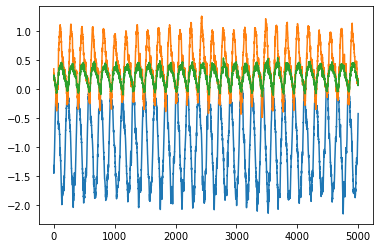

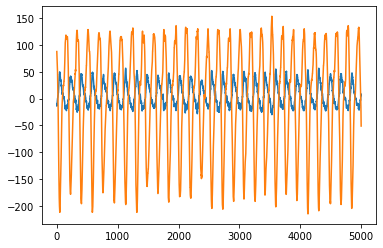

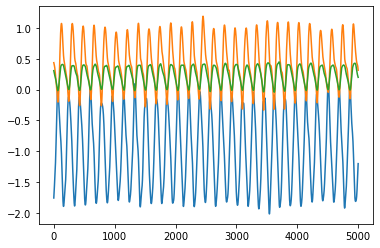

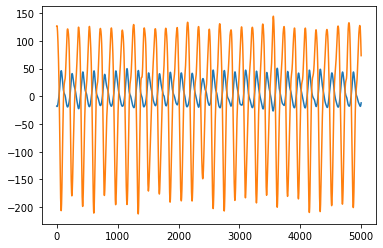

In [78]:
if __name__ == '__main__':
    data_visulization()
    noise_removing()